# This notebook illustrates how to annotate a visium H&E image  


In this notebook, we will annotate the visium H&E image extracted directly from the mapped 10X folder. 
We will load the image, and annotate it using various annotation tools. There are multiple options for image annotations: (1) fully-automatic - based on gene expression level, or (2) semi-automatic - based sparse manual labeling. Both (1) and (2) are used as a basis for prediction based on a pixel classifier. Finally,  we would finalise the image annotation based on manual annotation correction.
Annotations will be saved with the extension .pkl.

In [10]:
# initialisation 
import os
import panel as pn
import socket
import numpy as np
import tissue_tag as tt
import tissue_tag.annotation

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"
# host = '5011' # set the port to the value in the address bar when operating in farm
host = '8888' # when working locally e.g. desktop

In [11]:
# set path
# here you can either read a single image (grayscale or RGB) or generate a virtual H&E from 2 images in the next cell
Path = '../' #directory of tissuetag repo
path = Path +'data/tissue_tag_minimal_example_visium/' 

# Step 1 - Create de-novo annotations from gene expression (or not)

Load a visium image and downscale it to a more manageable size. `res_in_ppm` is the desired pixels per micron in the output.

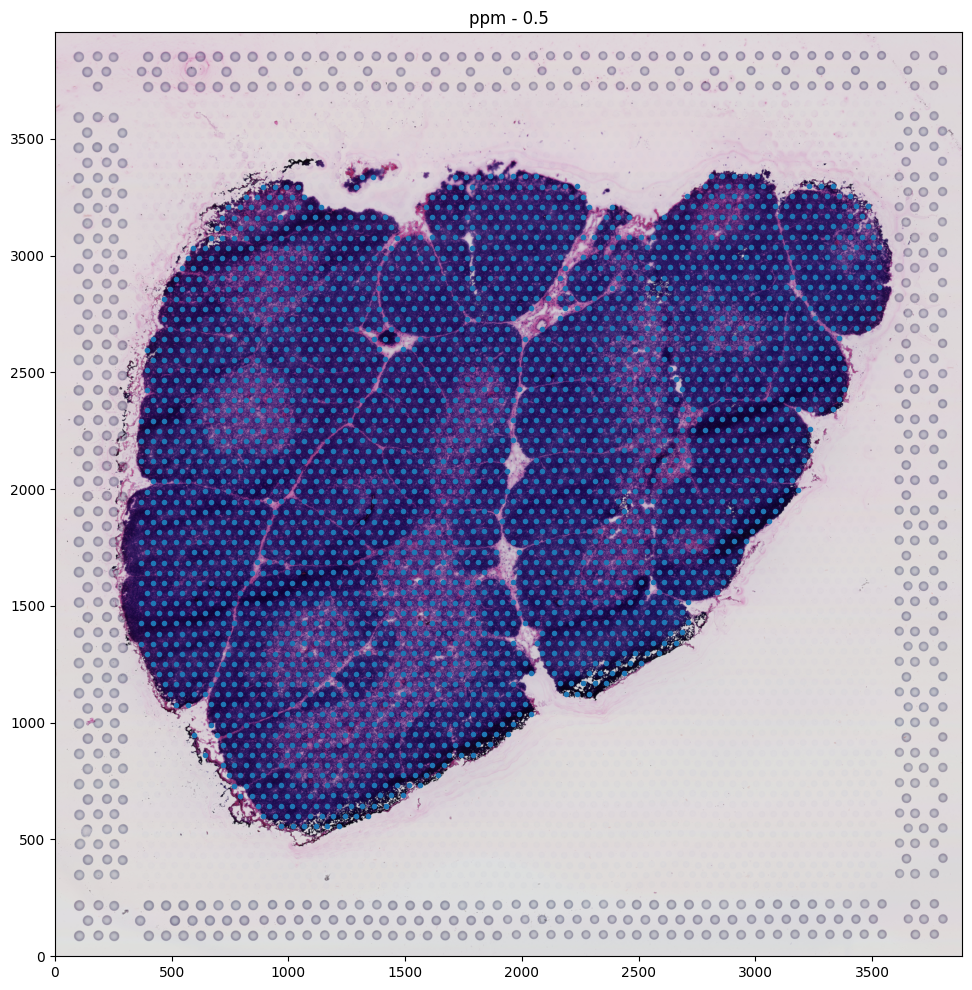

In [12]:
im,ppm_anno,df = tt.read_visium(spaceranger_dir_path=path,use_resolution='hires',res_in_ppm=0.5)

In [14]:
# define annotations 
annodict = {
    'Medulla': 'green',
    'Cortex': 'cyan',
    'Edge': 'brown',
    'HS': 'magenta',
    'Vessels': 'blue',
    'PVS': 'red',
    'Other': 'orange'
}
output = tissue_tag.annotation.LabelAnnotation(annotation_map=annodict)

### Add semi automatic annotations based on gene expression 
In this option we wil use a simple random forest pixel classifier to call the cortex and medullar regions of the H&E image. The training labels will be derived based on the spots that show the highest expression of the marker gene. 

In [15]:
# associate structures to marker genes and determine how many labels to generate from each spot.
gene_markers = { 
    'Medulla' : ('AIRE',30), # AIRE is highly expressed in the medulla (the marker for medullar TEC type 2 cells) 
    'Cortex' : ('ARPP21',300) # ARPP21 is highly expressed in the cortex
}

r = 35 # radius in microns for labels (27 is 1:1 label to visium spot - 55um diameter) but here i wanted to get some more context 

/Users/ay334/Repositories/TissueTag/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/ay334/Repositories/TissueTag/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


('AIRE', 30)
('ARPP21', 300)


/Users/ay334/Repositories/TissueTag/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/ay334/Repositories/TissueTag/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


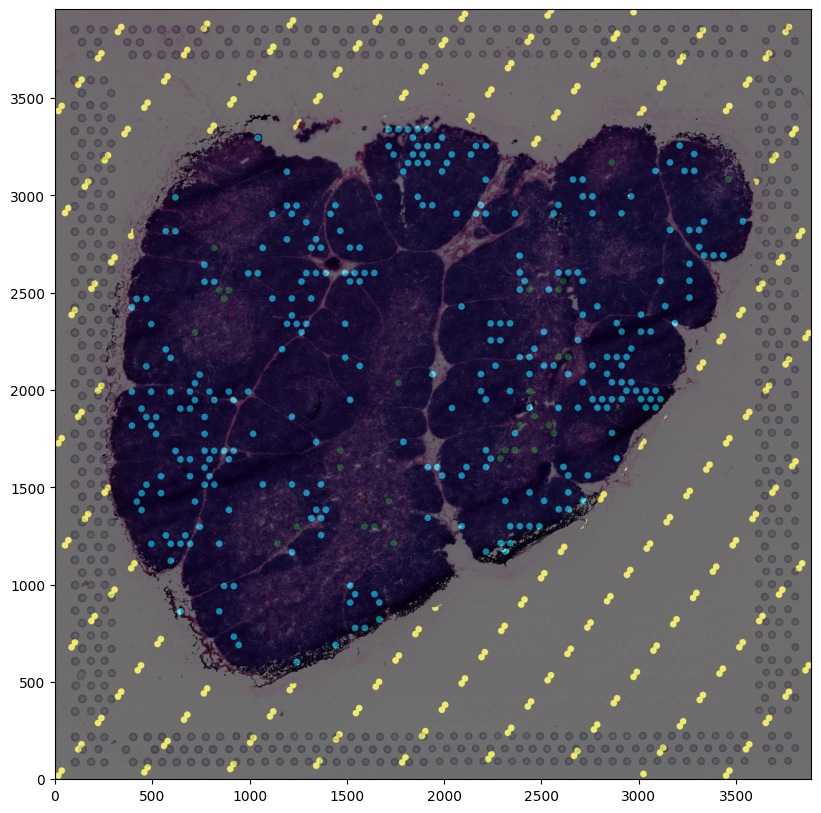

In [16]:
# generate training data from gene expression
output = tissue_tag.annotation.gene_labels(
    path = path,
    df = df,
    label_annotation = output,
    imarray=im,
    gene_markers = gene_markers,
    r = int(r*ppm_anno)
) # generate gene-marker-labels

out = tissue_tag.annotation.plot_labels(im, output, alpha=0.5)

# Part 2 - Iterative annotation section

At this stage, you can choose whether to use datashader - `use_datashader=True` for rendering the image (recommended for large images/high-resolution annotation). While the annotation process is slower with datashader, loading would be reasonable. If the image is too large, without datashader, the image might not load or take an extremely long time to load. 

Annotation is done by creating convex shapes in single strokes, the pixels inside the convex region would be filled in the `update_annotator` step. it's recommended to use a mouse with a wheel for easy scrolling in and out.
*to remove a label the use can click on the label to remove and press the backspace key. 

In [9]:
# use annotator to label tissue regions according to categories indicated above
annotator = tissue_tag.annotation.annotator(im, output, use_datashader=True)
pn.io.notebook.show_server(annotator, notebook_url=f'localhost:'+host)

['yellow', 'green', 'cyan', 'brown', 'magenta', 'blue', 'red', 'orange']


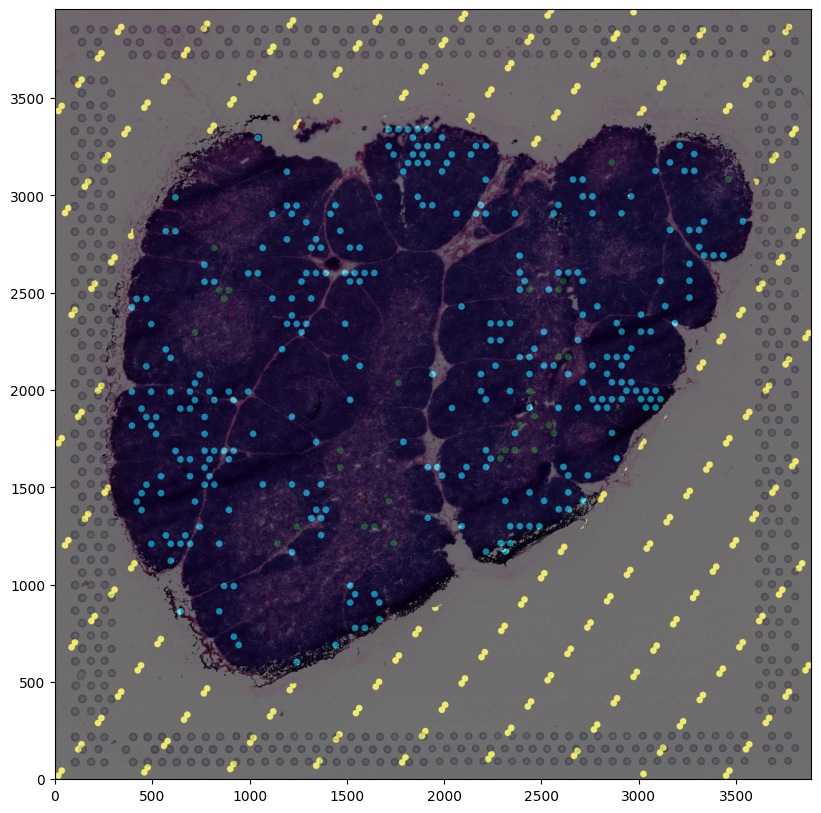

In [8]:
# This step fills in the shapes created for the pixel classifier
out_img = tissue_tag.annotation.plot_labels(im, output, alpha=0.5)

In [ ]:
%%time
# Train and predict the image pixels with a random forest classifier. This step takes about 1 to 10 min depending on number of training areas and resolution  
output = tissue_tag.annotation.sk_rf_classifier(im, output)

From this point go back to the annotator and correct annotations untill happy with results. 

# Part 3 - Finalise annotations and save

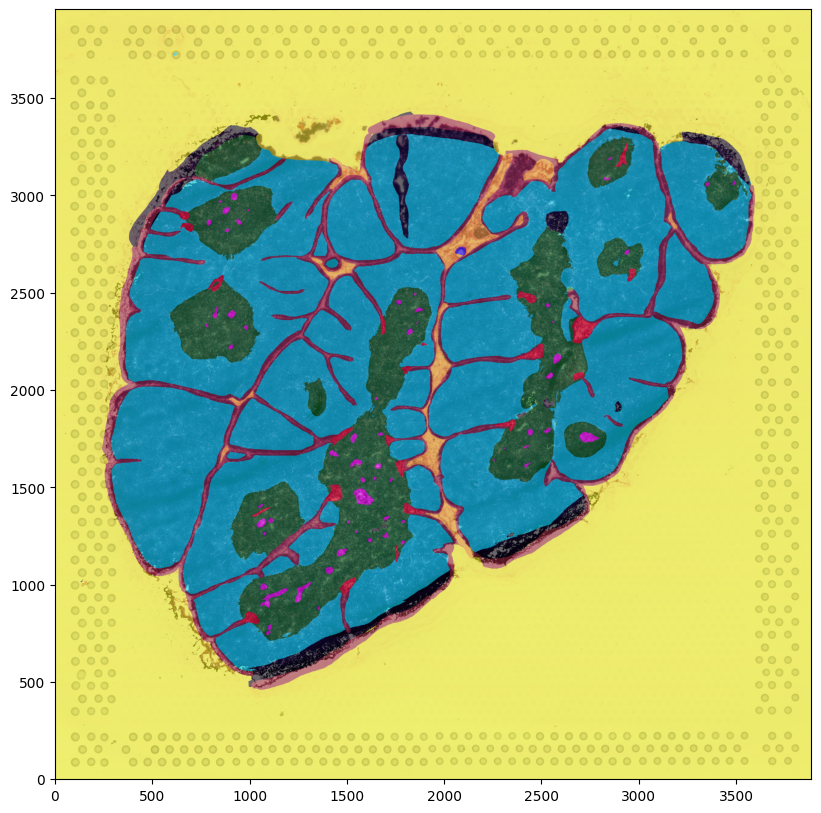

In [55]:
anno_img = tissue_tag.annotation.plot_labels(im, output, alpha=0.5)

#  Save annotations (and load)

The resulting images and information can be saved for later use.

In [18]:
isExist = os.path.exists(path+'tissue_annotations')
if not(isExist):
    os.mkdir(path+'/tissue_annotations/')
    
tissue_tag.annotation.save_annotation(
    folder=path+'/tissue_annotations/',
    file_name='annotations',
    label_annotation=output,
    ppm = ppm_anno
)

In [21]:
# optional - load annotations and as an intermediate step 
annotation_object, ppm = tissue_tag.annotation.load_annotation(folder=path + '/tissue_annotations/', file_name='annotations')

loaded annotation image - annotations size - (3957, 3886)
loaded annotation map
OrderedDict({'unassigned': 'yellow', 'Medulla': 'green', 'Cortex': 'cyan', 'Edge': 'brown', 'HS': 'magenta', 'Vessels': 'blue', 'PVS': 'red', 'Other': 'orange'})
loaded ppm
{'ppm': 0.5}
